In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sort_dataframe import process_missing_and_duplicate_timestamps as pmdt 
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#use given def to replace missing data with windowed average
df = pmdt(filepath='PJM_data\AEP_hourly.csv')

PJM_data\AEP_hourly.csv
Missing 2004-10-31 02:00:00 with average 10875
Missing 2005-04-03 03:00:00 with average 13348
Missing 2005-10-30 02:00:00 with average 13251
Missing 2006-04-02 03:00:00 with average 11285
Missing 2006-10-29 02:00:00 with average 13205
Missing 2007-03-11 03:00:00 with average 13104
Missing 2007-11-04 02:00:00 with average 13429
Missing 2008-03-09 03:00:00 with average 17193
Missing 2008-11-02 02:00:00 with average 12380
Missing 2009-03-08 03:00:00 with average 11027
Missing 2009-11-01 02:00:00 with average 11620
Missing 2010-03-14 03:00:00 with average 12602
Missing 2010-11-07 02:00:00 with average 14501
Missing 2010-12-10 00:00:00 with average 18225
Missing 2011-03-13 03:00:00 with average 12862
Missing 2011-11-06 02:00:00 with average 13363
Missing 2012-03-11 03:00:00 with average 13458
Missing 2012-11-04 02:00:00 with average 12522
Missing 2012-12-06 04:00:00 with average 14951
Missing 2013-03-10 03:00:00 with average 12486
Missing 2013-11-03 02:00:00 with ave

In [3]:
#set timestamp as index
df.index = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M', dayfirst=True)
df = df.drop(columns=['Datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121296 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121296 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [4]:
#read temperature data in Columbus, OH
OH_temp_df = pd.read_csv("PJM_data\columbus_OH_temperature.csv")

#set timestamp as index
OH_temp_df.index = pd.to_datetime(OH_temp_df['valid'], format='%Y-%m-%d %H:%M', dayfirst=True)




In [5]:
#shift timestamp forward 9 minutes to allow concatination of load profile df
OH_shift = OH_temp_df.shift(periods=9, freq='min')

OH_shift = OH_shift.drop(columns=['station', 'valid'])

OH_shift.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 171219 entries, 2004-01-01 01:00:00 to 2019-12-31 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   tmpf    171207 non-null  float64
dtypes: float64(1)
memory usage: 2.6 MB


In [6]:
df

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


In [7]:
df.isna().sum()

AEP_MW    0
dtype: int64

In [8]:
OH_shift

,tmpf
valid,
2004-01-01 01:00:00,41.00
2004-01-01 02:00:00,41.00
2004-01-01 03:00:00,37.94
2004-01-01 04:00:00,33.98
2004-01-01 05:00:00,32.00
...,...
2019-12-30 21:50:00,39.90
2019-12-30 22:00:00,39.90
2019-12-30 22:48:00,39.00


In [9]:
df2 = pd.concat([df, OH_shift], axis=1)
df2

,AEP_MW,tmpf
2004-01-01 01:00:00,NaN,41.00
2004-01-01 02:00:00,NaN,41.00
2004-01-01 03:00:00,NaN,37.94
2004-01-01 04:00:00,NaN,33.98
2004-01-01 05:00:00,NaN,32.00
...,...,...
2019-12-30 21:50:00,NaN,39.90
2019-12-30 22:00:00,NaN,39.90
2019-12-30 22:48:00,NaN,39.00
2019-12-30 23:00:00,NaN,39.00


In [10]:
df3 = df2['2004-10-02': '2018-08-02']

In [11]:
df3

,AEP_MW,tmpf
2004-10-02 00:00:00,13147.0,69.08
2004-10-02 01:00:00,12260.0,68.00
2004-10-02 02:00:00,11672.0,66.02
2004-10-02 03:00:00,11352.0,64.94
2004-10-02 04:00:00,11177.0,64.94
...,...,...
2018-08-02 19:00:00,18118.0,81.00
2018-08-02 20:00:00,17673.0,81.00
2018-08-02 21:00:00,17303.0,81.00
2018-08-02 22:00:00,17001.0,81.00


In [12]:
df3 = df3.dropna()
df3

,AEP_MW,tmpf
2004-10-02 00:00:00,13147.0,69.08
2004-10-02 01:00:00,12260.0,68.00
2004-10-02 02:00:00,11672.0,66.02
2004-10-02 03:00:00,11352.0,64.94
2004-10-02 04:00:00,11177.0,64.94
...,...,...
2018-08-02 19:00:00,18118.0,81.00
2018-08-02 20:00:00,17673.0,81.00
2018-08-02 21:00:00,17303.0,81.00
2018-08-02 22:00:00,17001.0,81.00


In [13]:
df3.isna().sum()

AEP_MW    0
tmpf      0
dtype: int64

In [14]:
df3.head()

,AEP_MW,tmpf
2004-10-02 00:00:00,13147.0,69.08
2004-10-02 01:00:00,12260.0,68.00
2004-10-02 02:00:00,11672.0,66.02
2004-10-02 03:00:00,11352.0,64.94
2004-10-02 04:00:00,11177.0,64.94


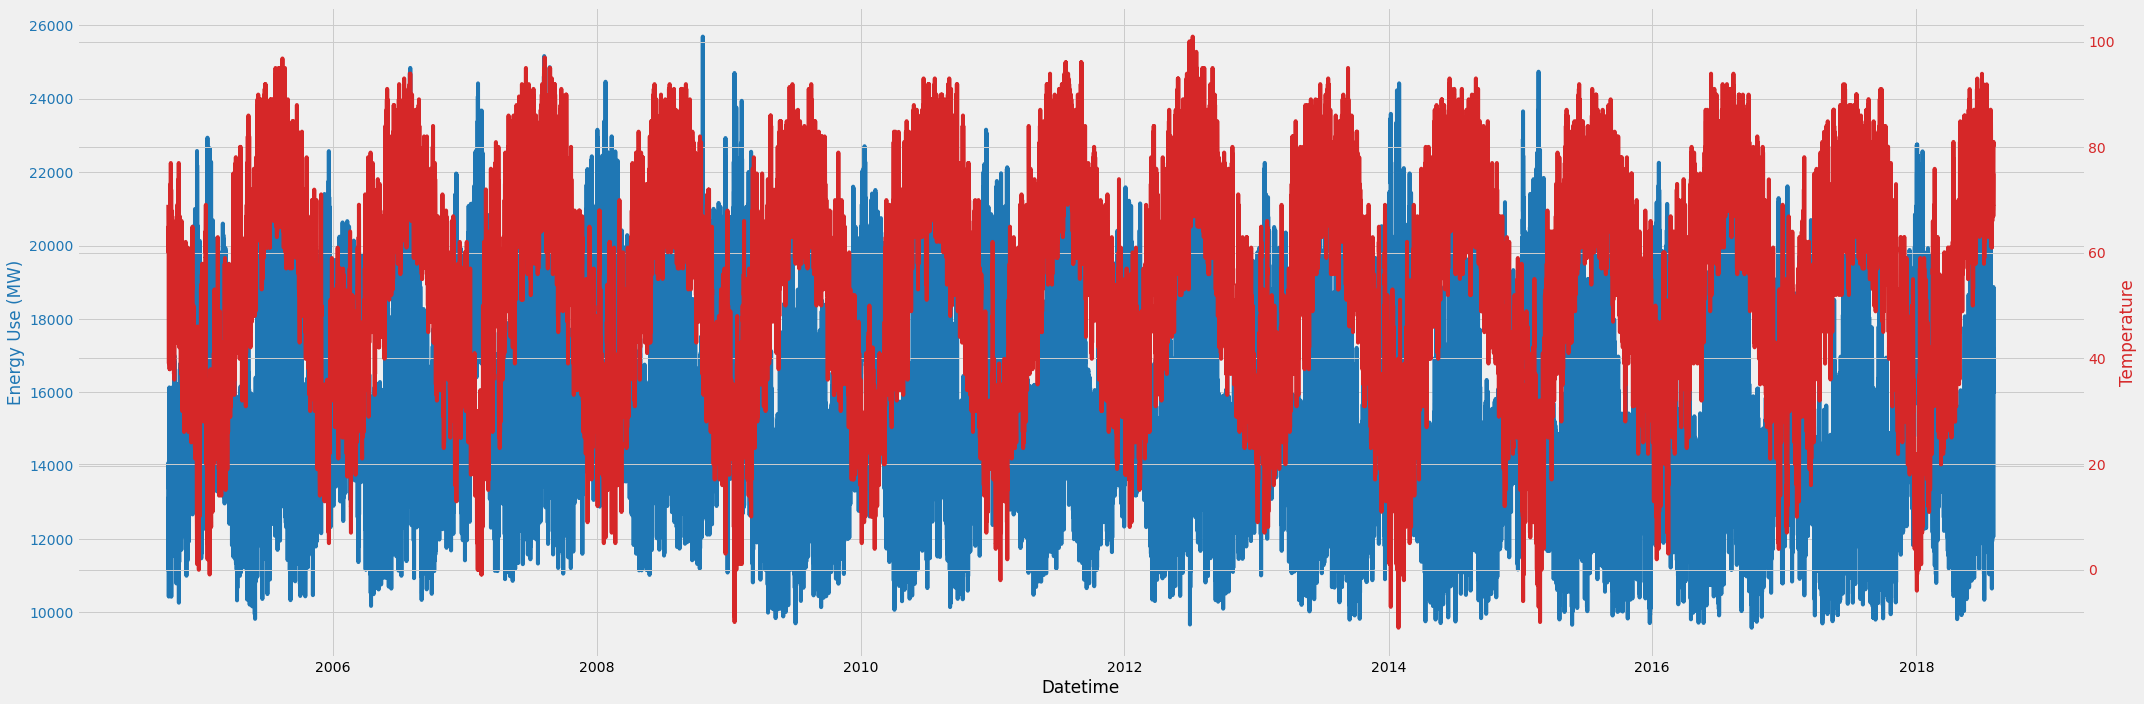

In [15]:

fig, ax1 = plt.subplots(figsize=(30, 10))

#Energy Load Profile
color = 'tab:blue'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Energy Use (MW)', color=color)
ax1.plot(df3.index, df3['AEP_MW'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

#Second axis
ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Temperature', color=color)  # we already handled the x-label with ax1
ax2.plot(df3.index, df3['tmpf'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()





plt.show()

Text(0, 0.5, 'Energy Use (MW)')

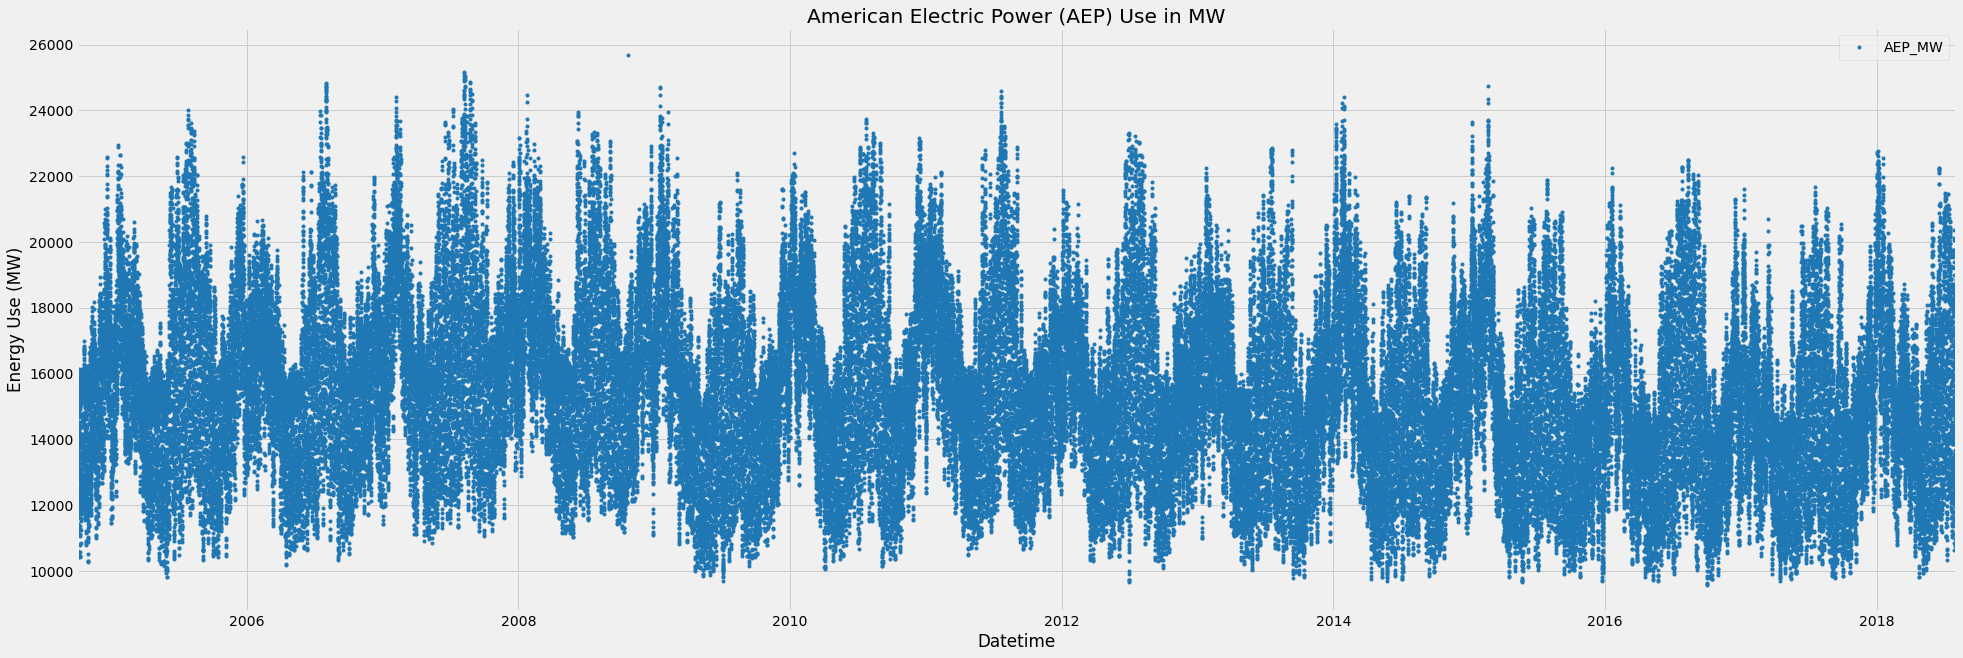

In [16]:
df.plot(y='AEP_MW', style='.',
        figsize=(30, 10),
        color=color_pal[0],
        title="American Electric Power (AEP) Use in MW")
plt.ylabel("Energy Use (MW)")

# Feature Creation

In [19]:
df3['hour'] = [df3.index[i].hour for i in range(len(df3))]
df3['month'] = [df3.index[i].month for i in range(len(df3))]
df3['dayofweek'] = [df3.index[i].day for i in range(len(df3))]

In [20]:
df3.head()

,AEP_MW,tmpf,hour,month,dayofweek
2004-10-02 00:00:00,13147.0,69.08,0,10,2
2004-10-02 01:00:00,12260.0,68.00,1,10,2
2004-10-02 02:00:00,11672.0,66.02,2,10,2
2004-10-02 03:00:00,11352.0,64.94,3,10,2
2004-10-02 04:00:00,11177.0,64.94,4,10,2
